In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00


In [14]:
#importing Libraries
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display
import joblib
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import files
uploaded = files.upload()


Saving merge_data_final.xlsx to merge_data_final.xlsx


In [15]:
# Sau khi tải lên, bạn có thể đọc file Excel như sau:
import pandas as pd
df = pd.read_excel('merge_data_final.xlsx')
df.head()

,TienSuYKhoa,ChamNoi,CungNhac,CoLap,ChoiGiaVo,HanhViLapLai,KyNangGiaoTiepSom,ChoiLuanPhien,BatChuoc,SaiViec,PhanUngTenGoi,ChiTro,ChuYLienKet,TiepXucMat,TargetBinary
0,0,1,0,1,0,0,1,1,0,1,0,0,1,1,1
1,0,1,0,1,0,1,1,0,0,1,0,1,1,1,1
2,0,1,0,0,1,0,1,0,0,0,1,1,1,1,1
3,0,0,0,0,1,1,1,0,1,0,1,1,1,1,1
4,0,1,0,0,1,0,1,0,1,0,1,1,1,1,1


In [5]:
for i, col in enumerate(df.columns):
    print(f"Vị trí {i}: {col}")

Vị trí 0: TienSuYKhoa
Vị trí 1: ChamNoi
Vị trí 2: CungNhac
Vị trí 3: CoLap
Vị trí 4: ChoiGiaVo
Vị trí 5: HanhViLapLai
Vị trí 6: KyNangGiaoTiepSom
Vị trí 7: ChoiLuanPhien
Vị trí 8: BatChuoc
Vị trí 9: SaiViec
Vị trí 10: PhanUngTenGoi
Vị trí 11: ChiTro
Vị trí 12: ChuYLienKet
Vị trí 13: TiepXucMat
Vị trí 14: TargetBinary


In [16]:
X = df.iloc[:, 0:14]      # lấy từ cột 0 đến 13 (14 đặc trưng)
y = df.iloc[:, 14]        # lấy cột TargetBinary (vị trí 14)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.5,
    random_state=42,
    shuffle=True,      # Có thể bỏ vì mặc định đã là True
    stratify=y         # Rất quan trọng trong bài toán classification
)
print(f"Kích thước tập train: {len(X_train)} dòng")
print(f"Kích thước tập test: {len(X_test)} dòng")

Kích thước tập train: 408 dòng
Kích thước tập test: 409 dòng


# TRAINING VÀ ĐÁNH GIÁ MODEL

In [ ]:
# KHÔNG CHẠY LẠI
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# 1. Khởi tạo mô hình CatBoostClassifier
model = CatBoostClassifier(
    verbose=0,           # tắt log hiển thị
    loss_function='Logloss',
    eval_metric='F1',    # hoặc 'AUC', tùy mục tiêu
    random_state=42
)

# 2. Thiết lập lưới tham số
param_grid = {
    'iterations': [100, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'bootstrap_type': ['Bayesian', 'Bernoulli'],
    'subsample': [0.7, 0.8]  # chỉ dùng nếu bootstrap_type ≠ 'No'
}

# 3. Thiết lập GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 4. Huấn luyện tìm tham số tốt nhất
grid.fit(X, y)

# 5. In kết quả
print("Best parameters found:")
print(grid.best_params_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

In [18]:
from catboost import CatBoostClassifier
# Khởi tạo mô hình với tham số tối ưu đã tìm được
model = CatBoostClassifier(
    iterations=300,              # số cây (vòng lặp boosting)
    depth=6,                     # độ sâu của cây
    learning_rate=0.01,          # tốc độ học
    l2_leaf_reg=5,               # regularization để tránh overfitting
    bootstrap_type='Bernoulli', # kiểu sampling
    subsample=0.7,               # tỉ lệ mẫu cho mỗi cây (chỉ dùng khi bootstrap ≠ None)
    loss_function='MultiClass', # dùng nếu bài toán nhiều lớp
    eval_metric='Accuracy',     # metric dùng để theo dõi
    random_state=42,
    verbose=False
)

# Huấn luyện mô hình
model.fit(X_train, y_train)


In [21]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
import pandas as pd

# 1. Dự đoán nhãn và xác suất
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # xác suất lớp 1 (nếu là binary)

# 2. Tính các độ đo
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# 3. Tạo bảng kết quả
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Score': [precision, recall, f1, roc_auc]
})
metrics_df['Score'] = metrics_df['Score'].round(3)

# 4. Hiển thị
print("=== Evaluation Metrics (Chạy đơn) ===")
print(metrics_df)


=== Evaluation Metrics (Chạy đơn) ===
      Metric  Score
0  Precision  0.885
1     Recall  0.942
2   F1-score  0.913
3    ROC-AUC  0.938


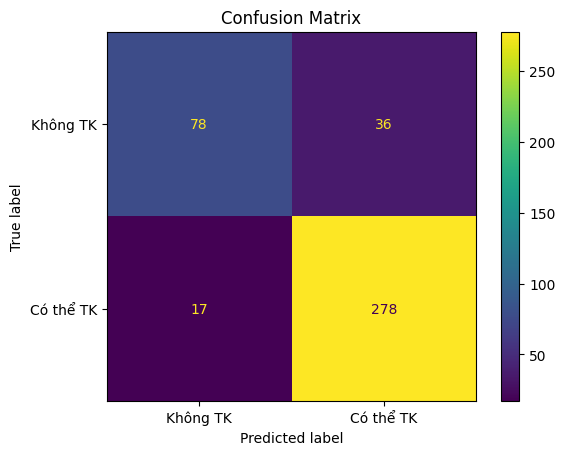

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Không TK', 'Có thể TK'])
plt.title("Confusion Matrix")
plt.show()


# Cross-Validation

In [23]:
from sklearn.model_selection import StratifiedKFold

# 2. Thiết lập Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Lưu độ đo
recall_scores = []
precision_scores = []
f1_scores = []
roc_auc_scores = []

# 4. Lặp qua từng fold
for train_index, test_index in kf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)
    y_proba_fold = model.predict_proba(X_test_fold)[:, 1]

    recall_scores.append(recall_score(y_test_fold, y_pred_fold))
    precision_scores.append(precision_score(y_test_fold, y_pred_fold))
    f1_scores.append(f1_score(y_test_fold, y_pred_fold))
    roc_auc_scores.append(roc_auc_score(y_test_fold, y_proba_fold))

# 5. Tạo DataFrame kết quả
results_df = pd.DataFrame({
    "Metric": ["Recall", "Precision", "F1-score", "ROC-AUC"],
    "Mean": [
        np.mean(recall_scores),
        np.mean(precision_scores),
        np.mean(f1_scores),
        np.mean(roc_auc_scores)
    ],
    "Std": [
        np.std(recall_scores),
        np.std(precision_scores),
        np.std(f1_scores),
        np.std(roc_auc_scores)
    ]
})

# Làm tròn 3 chữ số
results_df["Mean"] = results_df["Mean"].round(3)
results_df["Std"] = results_df["Std"].round(3)

# Hiển thị bảng
print(results_df)


      Metric   Mean    Std
0     Recall  0.930  0.022
1  Precision  0.876  0.025
2   F1-score  0.902  0.023
3    ROC-AUC  0.927  0.012


# KẾT LUẬN